In [1]:
import os
import sys
from crowdcounting import CrowdCountModelPose, CrowdCountModelMCNN, Router
import urllib
import base64
import io
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline

import os
import time
import base64
import urllib
from io import BytesIO
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from PIL import Image
import tensorflow as tf
import logging

from tf_pose import common
from tf_pose.common import CocoPart
from tf_pose.tensblur.smoother import Smoother

import sys

# dir_path = os.path.dirname(os.path.realpath(__file__))
# sys.path.append(dir_path + "/../third_party/mcnn/src")
# import network
# from crowd_count import CrowdCounter

from crowdcountmcnn.src import network
from crowdcountmcnn.src.crowd_count import CrowdCounter

from abc import ABC, abstractmethod

/Users/anthon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anthon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anthon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anthon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

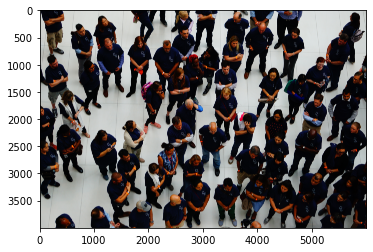

In [2]:
img = '../data/images/2.jpg'
pil_im = Image.open(img)
imshow(np.asarray(pil_im))

In [3]:
with open(img, 'rb') as image:
    b = image.read()

In [4]:
def init_model(gpu_id, model, w, h, config):
    """Initialize model.
    
    Args:
        gpu_id: GPU ID. 
    
    Returns:
        A TensorFlow model object.
    """

    # if w == 0 or h == 0:
    #     w, h = 432, 368

    if gpu_id == -1: # pragma: no cover
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), tf_config=config)
    else:
        with tf.device("/device:GPU:{}".format(gpu_id)):
            e = TfPoseEstimator(
                get_graph_path(model), target_size=(w, h), tf_config=config
            )
    return e

def score_openpose(e, image, w, h):
    """Score an image using OpenPose model.
    
    Args:
        e: OpenPose model.
        image: Image in CV2 format.
    
    Returns:
        Nubmer of people in image.
    """
    resize_out_ratio = 4.0
    humans = e.inference(
        image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio
    )
    return humans

def imresizeMaxDim(img, maxDim, boUpscale=False, interpolation=cv2.INTER_CUBIC):
    """Resize image.
    
    Args:
        img: Image in CV2 format. 
        maxDim: Maximum dimension. 
        boUpscale (optional): Defaults to False. 
        interpolation (optional): Defaults to cv2.INTER_CUBIC. 
    
    Returns:
        Resized image and scale.
    """
    scale = 1.0 * maxDim / max(img.shape[:2])
    if scale < 1 or boUpscale:
        img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=interpolation)
    else:
        scale = 1.0
    return img, scale

def create_openpose_image(filebytes, img_dim):
    """Create image from file bytes.
    
    Args:
        filebytes: Image in stream.
        img_dim: Max dimension of image.
    
    Returns:
        Image in CV2 format. 
    """
    # file_bytes = np.asarray(bytearray(BytesIO(filebytes).read()), dtype=np.uint8)
    file_bytes = np.fromstring(filebytes, np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    img, _ = imresizeMaxDim(img, img_dim)
    return img

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = True
model = "cmu"
resize = "656x368"
w, h = model_wh(resize)
model = init_model(-1, model, w, h, config)

img = create_openpose_image(b, 1750)


humans = score_openpose(model, img, w, h)
print(len(humans))

[2021-01-26 15:56:46,894] [TfPoseEstimator] [INFO] loading graph from /Users/anthon/opt/anaconda3/lib/python3.7/site-packages/tf_pose_data/graph/cmu/graph_opt.pb(default size=656x368)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/anthon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


86


In [6]:
def normalize(data):
    _range = np.max(data)-np.min(data)
    return (data - np.min(data)) / _range

def crowdedness(coordinates_x, coordinates_y):
    coor_x = normalize(coordinates_x)
    coor_y = normalize(coordinates_y)
    centroid_x = np.sum(coor_x) / len(coor_x)
    centroid_y = np.sum(coor_y) / len(coor_y)
    dist = np.sum(np.square(coor_x - centroid_x)) + np.sum(np.square(coor_y - centroid_y))
    print(dist/len(coor_x))
    

0.1656350581583497
60


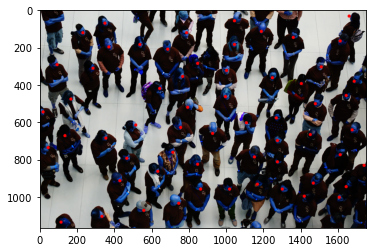

In [7]:
npimg = np.copy(img)
image_h, image_w = img.shape[:2]
cnt = 0
coor_x = []
coor_y = []
for human in humans:
    if 0 not in human.body_parts.keys():
        continue
    cnt = cnt + 1
    body_part = human.body_parts[0]
    center = (int(body_part.x * image_w + 0.5), int(body_part.y * image_h + 0.5))
    coor_x.append(center[0])
    coor_y.append(center[1])
    cv2.circle(npimg, center, 3, common.CocoColors[0], thickness=10, lineType=8, shift=0)
imshow(npimg)
crowdedness(coor_x, coor_y)
print(cnt)

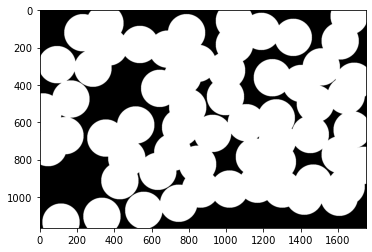

In [8]:
black_img = np.zeros([image_h, image_w, 3], np.uint8)
density_img = np.copy(black_img)
for i in range(len(coor_x)):
    cv2.circle(density_img,(coor_x[i],coor_y[i]),radius=100,color=(255,255,255),thickness=-1)
imshow(density_img)

In [16]:
def get_crowdedness(n, area, density_img):
    h, w = density_img.shape[:2]
    cnt = 0
    for r in range(h):
        for c in range(w):
            b, g, r = density_img[r][c][:]
            if b + g + r == 0 * 3:
                cnt = cnt + 1
    den = n / area
    clus = w * h / cnt
    cr = den * clus
    print(density_img[0][0])
    return cr

In [17]:
get_crowdedness(cnt, 100, density_img)

/Users/anthon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


[0 0 0]


0.871141943492189